# **FRAUD DETECTION - DATA AUGMENTATION & ANONYMIZATION USING GAN**
In this notebook, you will find examples of how to use the generative library created by students from Essec & CentraleSupélec in collaboration with SIA Partners on the case of fraud detection model improvement and anonymization.

The notebook is organized in the following way:

*   **PART I: GAN-based data augmentation to solve for class imbalance in a fraud detection problem**

*   **PART II: GAN-based data anonymization (with data augmentation) to allow for privacy-preserving data sharing while maintaining performance.**

*Useful resources*:



*   The github repository containing the source code and documentation for the generative method used: [here](https://github.com/oskargirardin/CRP_GDPR_datasets).
*   The medium article explaining the approach and logical thinking behind this notebook: here (LINK TO BE INSERTED).

For any questions or remarks, please contact xx@xx.com.[link text](https://)


## Preliminary work: 

## LOADING LIBRARIES AND IMPORTS

#### Libraries and Imports:

In [ ]:
#Not run unless issues with Numpy
!pip uninstall numpy
!pip install numpy

In [ ]:
!pip install torch==1.13.1
! pip install sdv
! pip install faker
! pip install realtabformer

In [ ]:
pip install --upgrade accelerate

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# import libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

### Loading our generative methods library

In [ ]:
from generator import *
from SimilarityCheck import *
from privacy_check import *
from augmentation import *
from generator_augment import *

## IMPORTING AND PREPROCESSING THE DATA

### Data import

In this example, we will be using a data set from Kaggle. If you want to run this notebook with the same data, make sure you load a kaggle.json file. 

To find the kaggle.json, go to your kaggle account, Scroll to API section and click Expire API Token to remove previous tokens. Then, click on Create New API Token - It will download kaggle.json file on your machine. Finally, run the following cell.

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d incarnyx/car-insurance-fraud
!unzip car-insurance-fraud.zip

In [ ]:
df = pd.read_excel("Dataset.xlsx")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Data preprocessing

This step is to be done on the side of the data controller. Without having access to the data, the data processor can do the following:



*   Ask the data controller for a schema of the table containing the data and a sample of the data, which can be made up. The point is to be able to design the appropriate pre-processing step to allow for an efficient use with the GAN later on.



#### Preprocessing function

In [ ]:
months = {
    'Jan' : 1,
    'Feb' : 2,
    'Mar' : 3,
    'Apr' : 4,
    'May' : 5,
    'Jun' : 6,
    'Jul' : 7,
    'Aug' : 8,
    'Sep' : 9, 
    'Oct' : 10,
    'Nov' : 11,
    'Dec' : 12
          }
months_proc = lambda x: months.get(x, 0)

D_o_w = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
          }
D_o_w_proc = lambda x: D_o_w.get(x, 0)

vehicle_prices = {
    'less than 20000': 1,
    '20000 to 29000' : 2,
    '30000 to 39000' : 3,
    '40000 to 59000' : 4,
    '60000 to 69000' : 5,
    'more than 69000': 6,
          }
vehicle_price_proc = lambda x: vehicle_prices.get(x, 0)

AgeOfVehicle_variants = {
    'new'         : 0.5,
    '2 years'     : 2,
    '3 years'     : 3,
    '4 years'     : 4,
    '5 years'     : 5,
    '6 years'     : 6,
    '7 years'     : 7,
    'more than 7' : 8.5,
          }
vehicle_age_proc = lambda x: AgeOfVehicle_variants[x]

age_variants = {
    '16 to 17'     : 1,
    '18 to 20'     : 2,
    '21 to 25'     : 3,
    '26 to 30'     : 4,
    '31 to 35'     : 5,
    '36 to 40'     : 6,
    '41 to 50'     : 7,
    '51 to 65'     : 8,
    'over 65'      : 9,
          }
age_proc = lambda x: age_variants[x]

#this function creates the dummies for 1 column
def create_dummy(col, df):
    df_dummy = pd.get_dummies(df[col], drop_first = True)
    df_dummy.columns = ['dum: ' + str(col) + ': ' + str(name) for name in df_dummy.columns]
    return df_dummy

#this function uses the previous function to create dummies for all columns that need them
def dummies(df):
    dummy_df = pd.DataFrame()
    object_cols = df.columns[df.dtypes == object]
    for col in object_cols:
        dummy_df = pd.concat([dummy_df, create_dummy(col, df)], axis = 1)
    
    df_out = pd.concat([df.drop(columns = object_cols), dummy_df.astype('int32')], axis = 1)
    return df_out.sort_index(ascending=False, axis=1)



def preprocessing(df):
  df = df.dropna(axis = 0)
  df = df[df['Age'] > 0.0]
  df['Month'] = df['Month'].apply(months_proc)
  df['MonthClaimed'] = df['MonthClaimed'].apply(months_proc)
  df['DayOfWeek'] = df['DayOfWeek'].apply(D_o_w_proc)
  df['DayOfWeekClaimed'] = df['DayOfWeekClaimed'].apply(D_o_w_proc)
  df['VehiclePrice'] = df['VehiclePrice'].apply(vehicle_price_proc)
  df['AgeOfVehicle'] = df['AgeOfVehicle'].apply(vehicle_age_proc)
  df['AgeOfPolicyHolder'] = df['AgeOfPolicyHolder'].apply(age_proc)
  df = dummies(df)
  return df

#### Apply function

In [ ]:
df = preprocessing(df)

In [ ]:
pfraud = len(df[df['FraudFound_P']==1])/len(df)
print(f"Probability of fraud in the dataset:{round(pfraud,2)*100}%")

Probability of fraud in the dataset:6.0%


This dataset is very imbalanced, as only 6% of datapoints are fraud. To avoid building inefficient models, we need to do data augmentation to increase the number of fraudulent samples.

## PART I: DATA AUGMENTATION

### Increase the sample from the minority class

To augment the minority class, we call the `augmentation` function. The parameters of the function are the following:



*   `data`: the dataset that we want to augment
*   `target_col`: The target variable, containing the classes that we want to predict.
*   `architecture`: the architecture we want to use. Can be 'RealTabFormer', 'CTGAN' or 'GaussianCopula'. 
*   `p_fraud`: the proportion of the target class in the augmented dataset.
*   `n_epochs`: number of epochs to train the generator
*   `n_bootsrap`: Number of bootstraps for RealTabFormer, default is 500.
*   `verbose`: Whether to print fit progress on stdout in 'CTCGAN' architecture, default False



The function returns the `metadata` of the new dataset, as well as the `dataset` itself.



In [ ]:
metadata, augmented_df = augmentation(df, "FraudFound_P", 'RealTabFormer', 0.3, 5, 50)

Retrieving metadata, check with generator.metadata
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 5...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.001185
std       0.011816
min      -0.020556
25%      -0.006944
50%      -0.000185
75%       0.005185
max       0.035370
dtype: float64
Sensitivity threshold: 0.024574074074074068 qt_max: 0.05


Map:   0%|          | 0/659 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,0.996700


  0%|          | 0/324 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 384 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.024574074074074068,                         val_sensitivity: 0.0024567901234567886,                             val_sensitivities: [-0.006851851851851854, 0.01648148148148148, 0.0009259259259259238, 0.002407407407407406, -0.014629629629629631, 0.01388888888888889, 0.01388888888888889, 0.020555555555555553, 0.024259259259259258, 0.003888888888888887, -0.009074074074074076, -0.008333333333333335, -0.011296296296296299, 0.0009259259259259231, -0.010185185185185188]


  0%|          | 0/4184 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 4224 samples generated. Sampling efficiency is: 100.0000%
------Dataset has been successfully augmented!------


In [ ]:
pfraud = len(augmented_df[augmented_df['FraudFound_P']==1])/len(augmented_df)
print(f"Probability of fraud in the dataset: {round(pfraud,2)*100}%")

Probability of fraud in the dataset: 31.0%


The classes have been rebalanced as desired. In our experience, it is not always optimal to make the classes' sizes even, as the minority class can then be overpredicted.  

## PART II: DATA AUGMENTATION AND FULL ANONYMIZATION

In this part, we present the pipeline for generating a fully synthesized and augmented dataset. In the event we need to augment and synthesize the data, we split the data in as many parts as we have target classes. Then, the number of samples needed can be controlled with the `Generator` object.

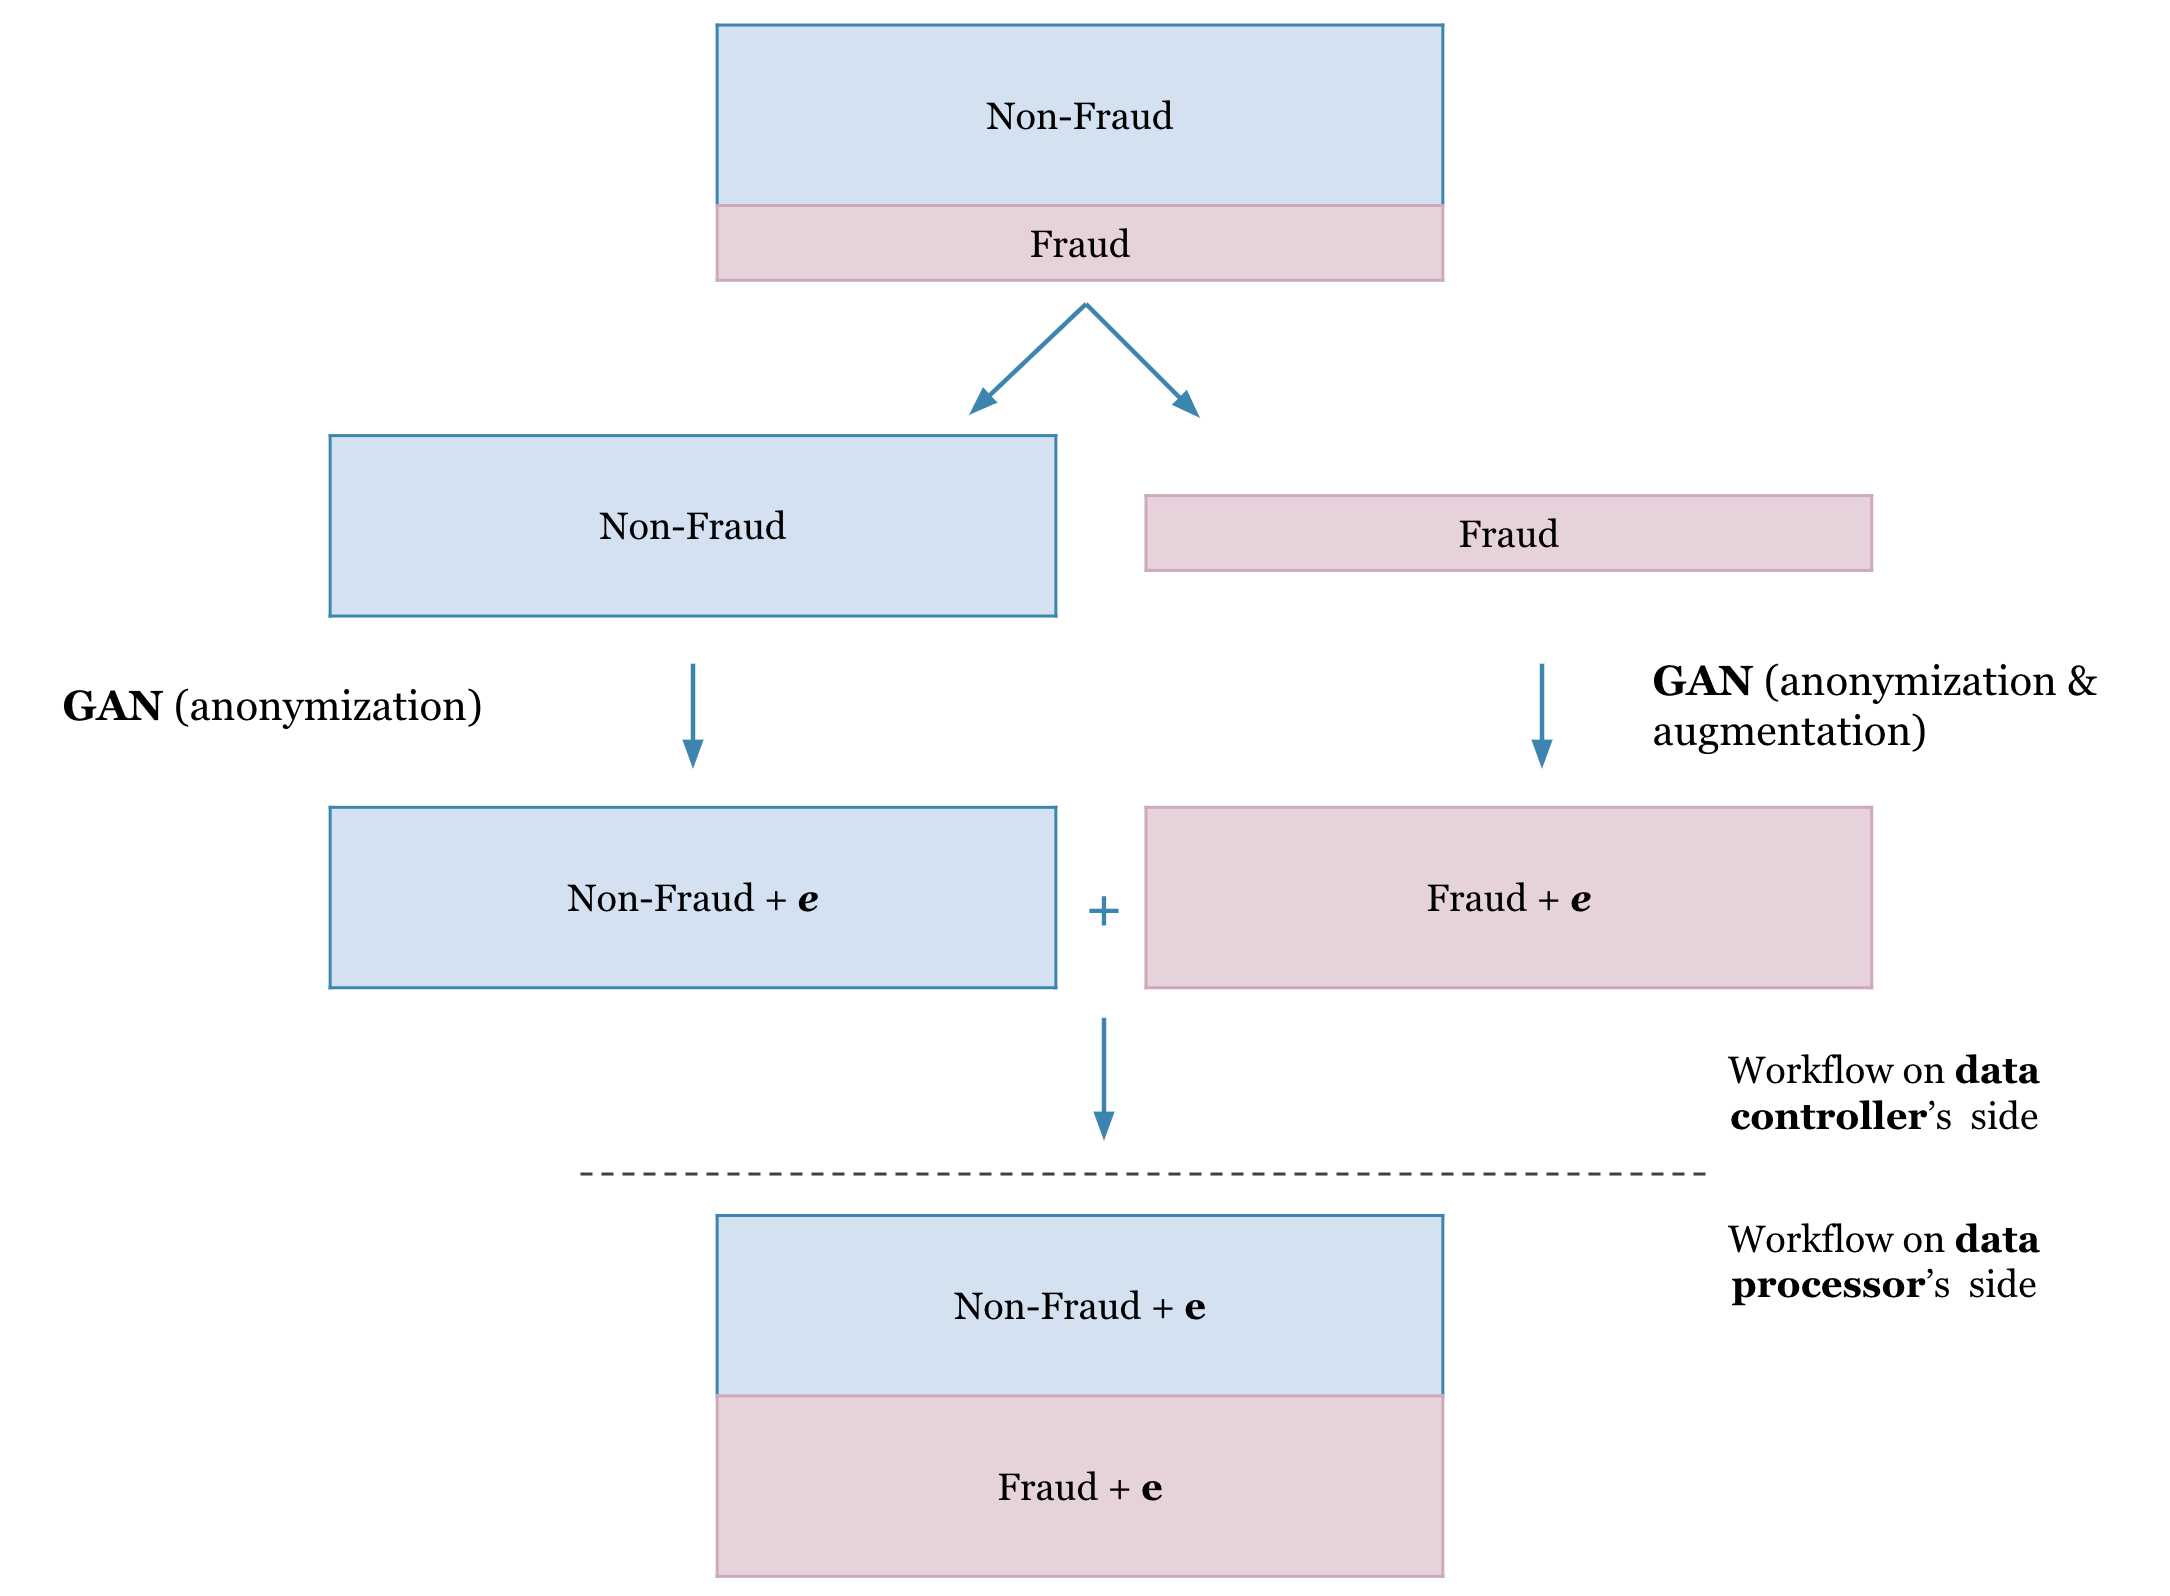

To augment the minority class, we call the `generator_augmentation` function. The parameters of the function are the following:



*   `data`: the dataset that we want to augment
*   `architecture`: the architecture we want to use. Can be 'RealTabFormer', 'CTGAN' or 'GaussianCopula'. 
*   `n_samples`: the number of rows to generate in total.
*   `p_fraud`:  size of the minority class (to augment) relative to the total sample
*   `n_epochs_nofraud`: the number of epochs used for training of the non fraud subsample.
*   `n_epochs_fraud`: the number of epochs used for training of the fraud subsample
*   `n_bootsrap`: Number of bootstraps for RealTabFormer, default is 500.
*   `target_col`: The target variable, containing the classes that we want to predict.
*   `sensitive_cols`:a dict with sensitive columns and what  category they belong to.
*   `verbose`: Whether to print fit progress on stdout in 'CTCGAN' architecture, default is False



The function returns the `metadata` of the new dataset, as well as the `dataset` itself.



In [ ]:
metadata, synth = generator_augmentation(df, "RealTabFormer", 10642, 0.3, 5, 5, 50, "FraudFound_P")

Retrieving metadata, check with generator.metadata
Retrieving metadata, check with generator.metadata
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 87...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.000111
std       0.002620
min      -0.005001
25%      -0.001948
50%       0.000437
75%       0.001705
max       0.006397
dtype: float64
Sensitivity threshold: 0.0036680420473523922 qt_max: 0.05


Map:   0%|          | 0/10642 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,0.958200
200,0.614800
300,0.588000
400,0.576900
500,0.570800
600,0.563100
700,0.559700
800,0.554400
900,0.554000
1000,0.551500


  0%|          | 0/5265 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 5376 samples generated. Sampling efficiency is: 100.0000%
Saving not-best model...
Critic round: 5,                     sensitivity_threshold: 0.0036680420473523922,                         val_sensitivity: 0.004707262228335026,                             val_sensitivities: [0.004551036447588172, 0.0020832105314863947, 0.0038044012181943213, 0.006066574974620952, 0.005705046337230245, 0.0039746864459508134, 0.007540197137898288, 0.00476192815273275, 0.004940072698693388, 0.0058858106559255986, 0.0036707928087238435, 0.006116350656580542, 0.004632249402364345, 0.00448554212922029, 0.002391033827815437]


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:830: UserWarning: No best model was saved. Loading the closest model to the sensitivity_threshold.
  warnings.warn(


  0%|          | 0/7449 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 7552 samples generated. Sampling efficiency is: 100.0000%
Computing the sensitivity threshold...


/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 5...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.001185
std       0.011816
min      -0.020556
25%      -0.006944
50%      -0.000185
75%       0.005185
max       0.035370
dtype: float64
Sensitivity threshold: 0.024574074074074068 qt_max: 0.05


Map:   0%|          | 0/659 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,0.996700


  0%|          | 0/324 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 384 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.024574074074074068,                         val_sensitivity: 0.0024567901234567886,                             val_sensitivities: [-0.006851851851851854, 0.01648148148148148, 0.0009259259259259238, 0.002407407407407406, -0.014629629629629631, 0.01388888888888889, 0.01388888888888889, 0.020555555555555553, 0.024259259259259258, 0.003888888888888887, -0.009074074074074076, -0.008333333333333335, -0.011296296296296299, 0.0009259259259259231, -0.010185185185185188]


  0%|          | 0/3193 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3200 samples generated. Sampling efficiency is: 100.0000%


In [ ]:
pfraud = len(synth[synth['FraudFound_P']==1])/len(synth)
print(f"Probability of fraud in the dataset: {round(pfraud,2)*100}%")

Probability of fraud in the dataset: 30.0%


In [ ]:
from google.colab import files
synth.to_csv('synthetic_df.csv') 
files.download('synthetic_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Similarity Check**

#### Creating similarity check object

In [ ]:
categorical_columns = []

for col in list(df):
    if df[col].dtypes == 'object':
        categorical_columns.append(col)

similarity_checker = SimilarityCheck(df, synth, 
                                      categorical_columns, metadata)

#### Simple comparison of columns

In [ ]:
similarity_checker.comparison_columns()

Here is the type of output that one can expect to get with this method:

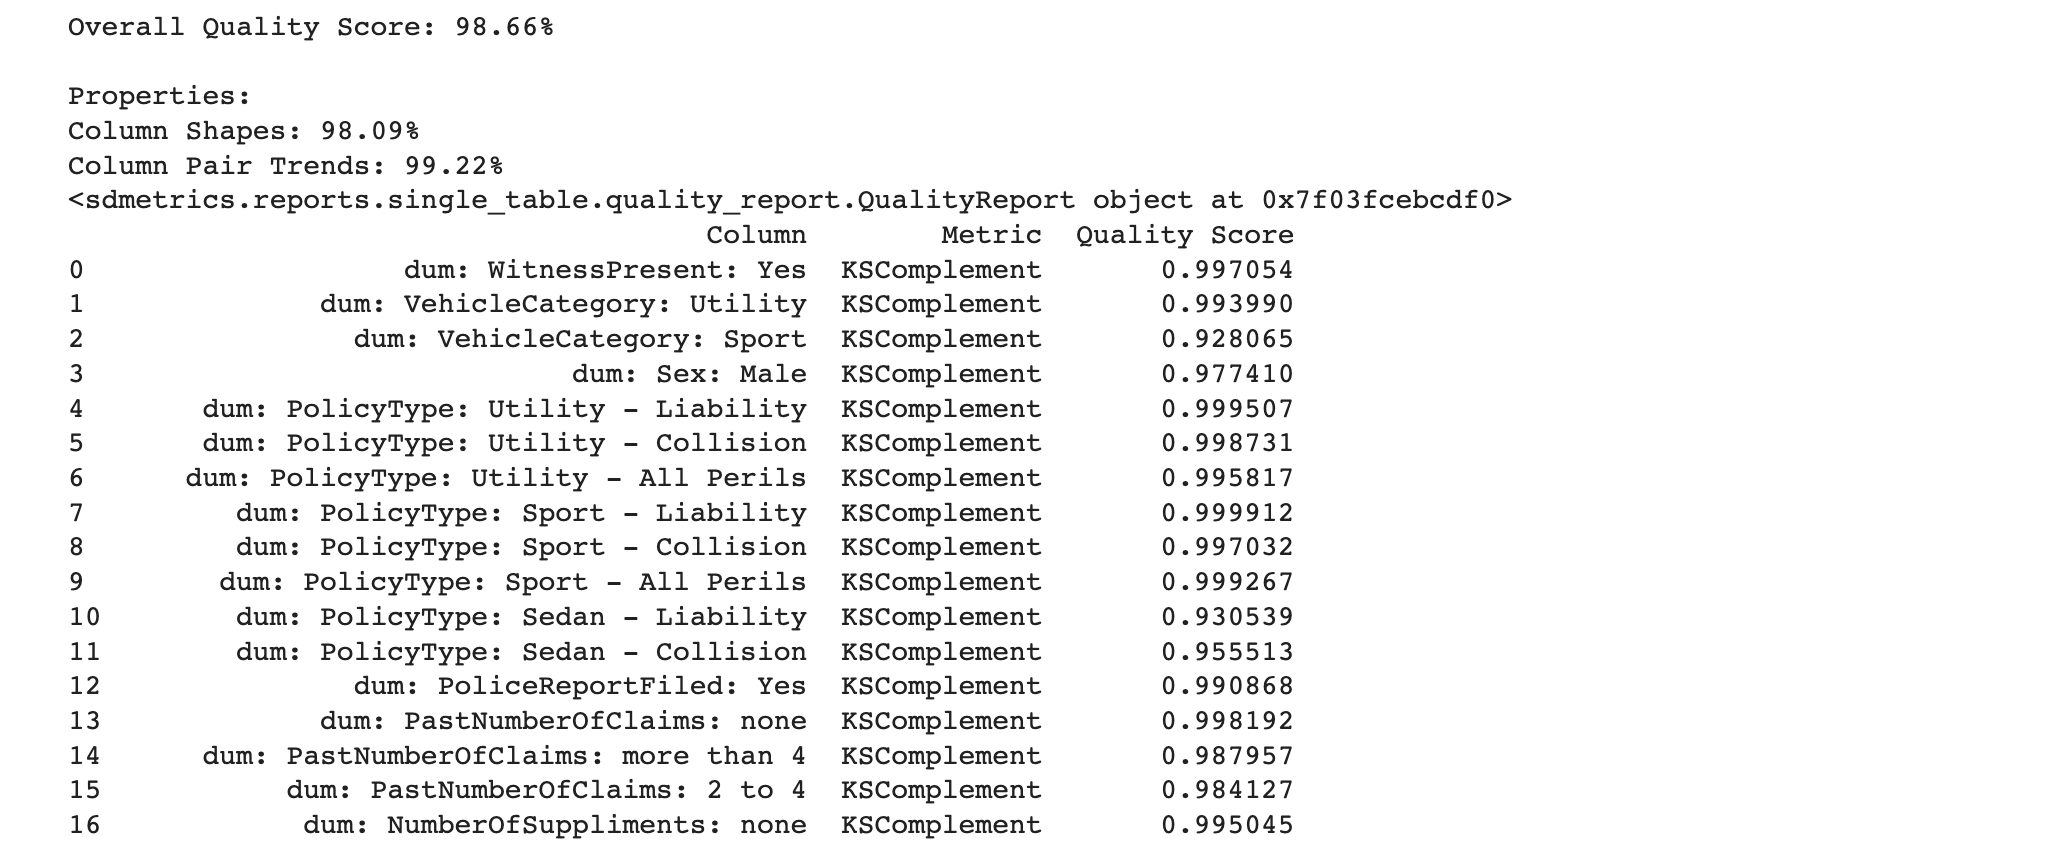

#### Visual comparison of the columns' distribution

In [ ]:
similarity_checker.visual_comparison_columns() 

Here is an example of the output of this method:

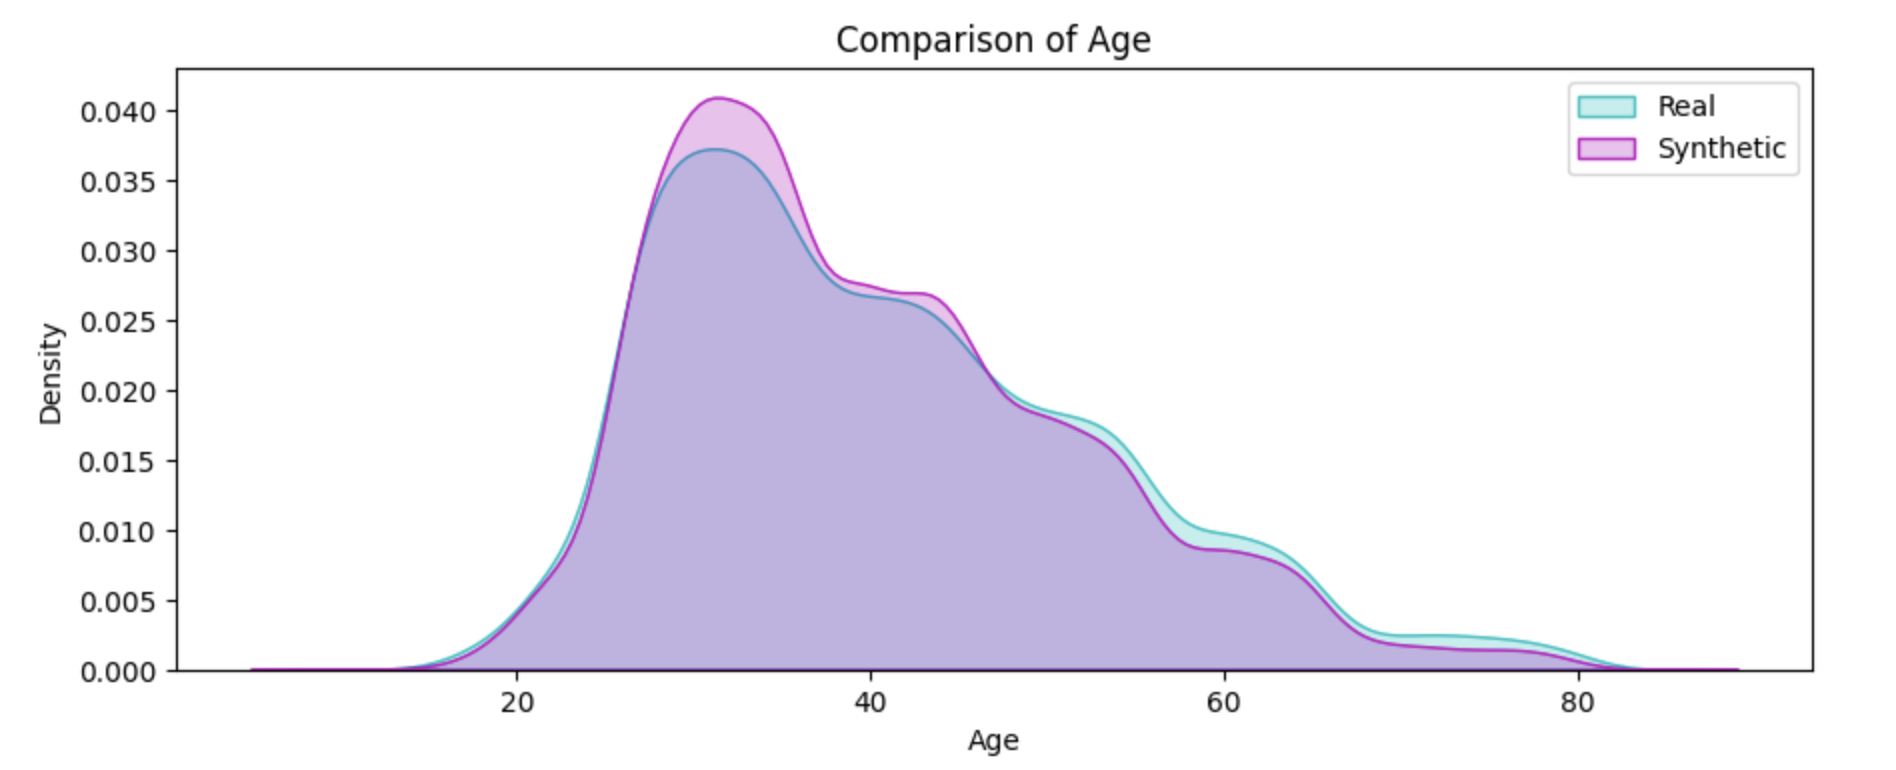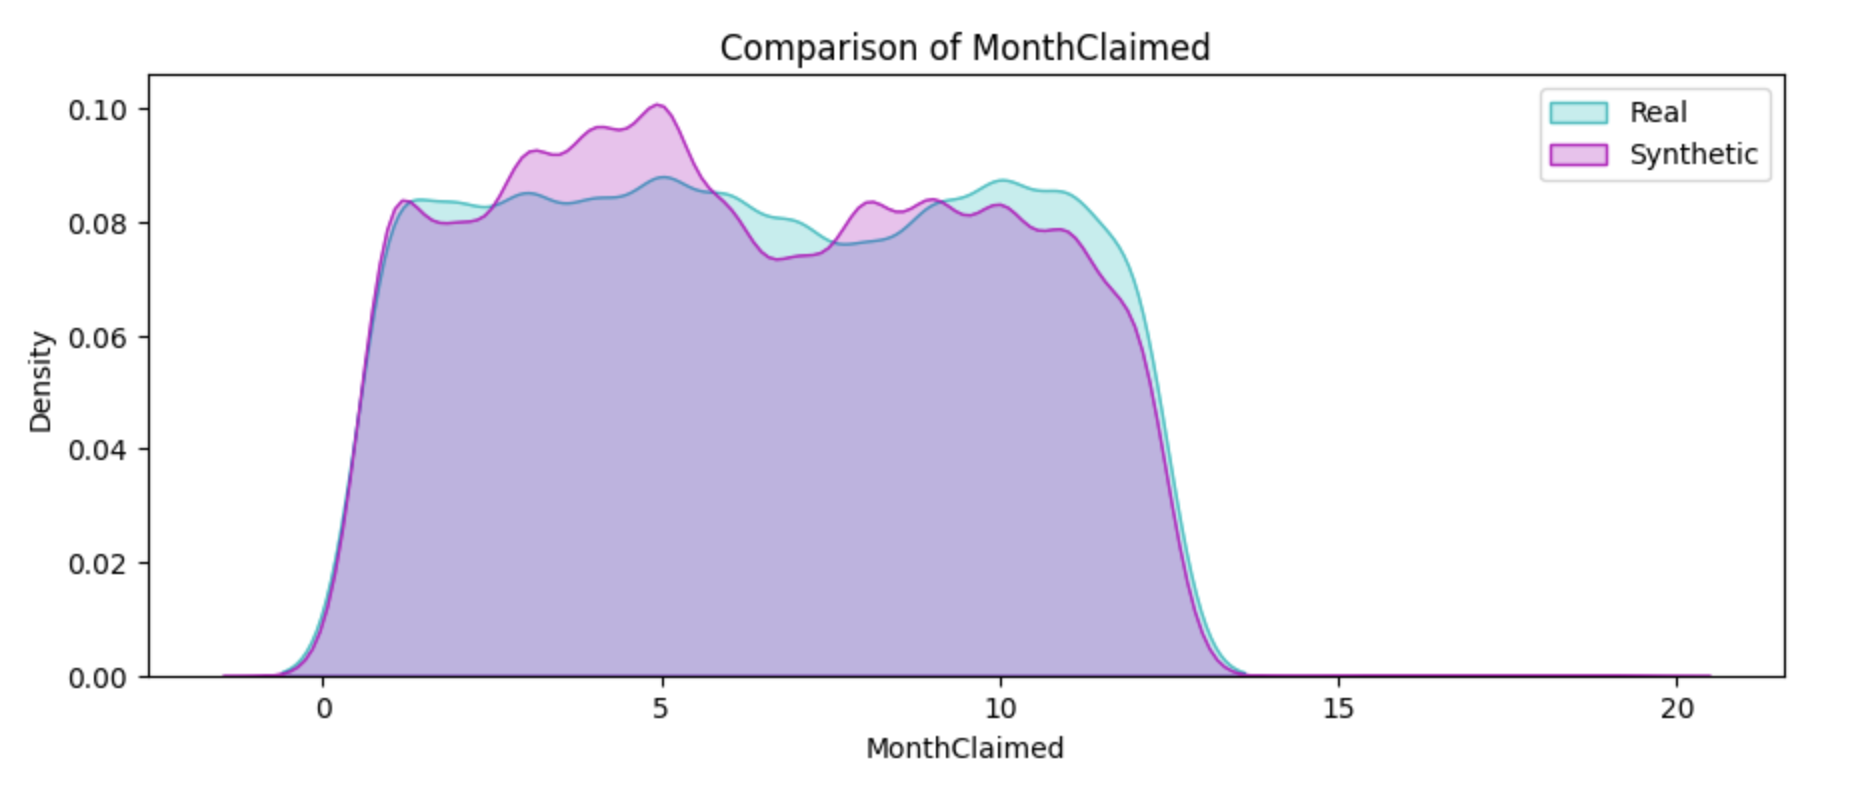

#### Correlation difference matrix

Here, `features` variable allows to specify for which columns we want to see the differences in correlations. By default, it's None, in that case you will see the matrix for all variables.

In this example, we see that there is a 0.27 difference in correlation between vehicle price and claim size in the synthetic data, compared to the original data.

In [ ]:
similarity_checker.compare_correlations(features = ['WeekOfMonthClaimed', 'VehiclePrice', 'MonthClaimed', 'PolicyNumber', 'DayOfWeek', 'ClaimSize', 'AgeOfVehicle', 'FraudFound_P']) 

Here an example of output of this method:

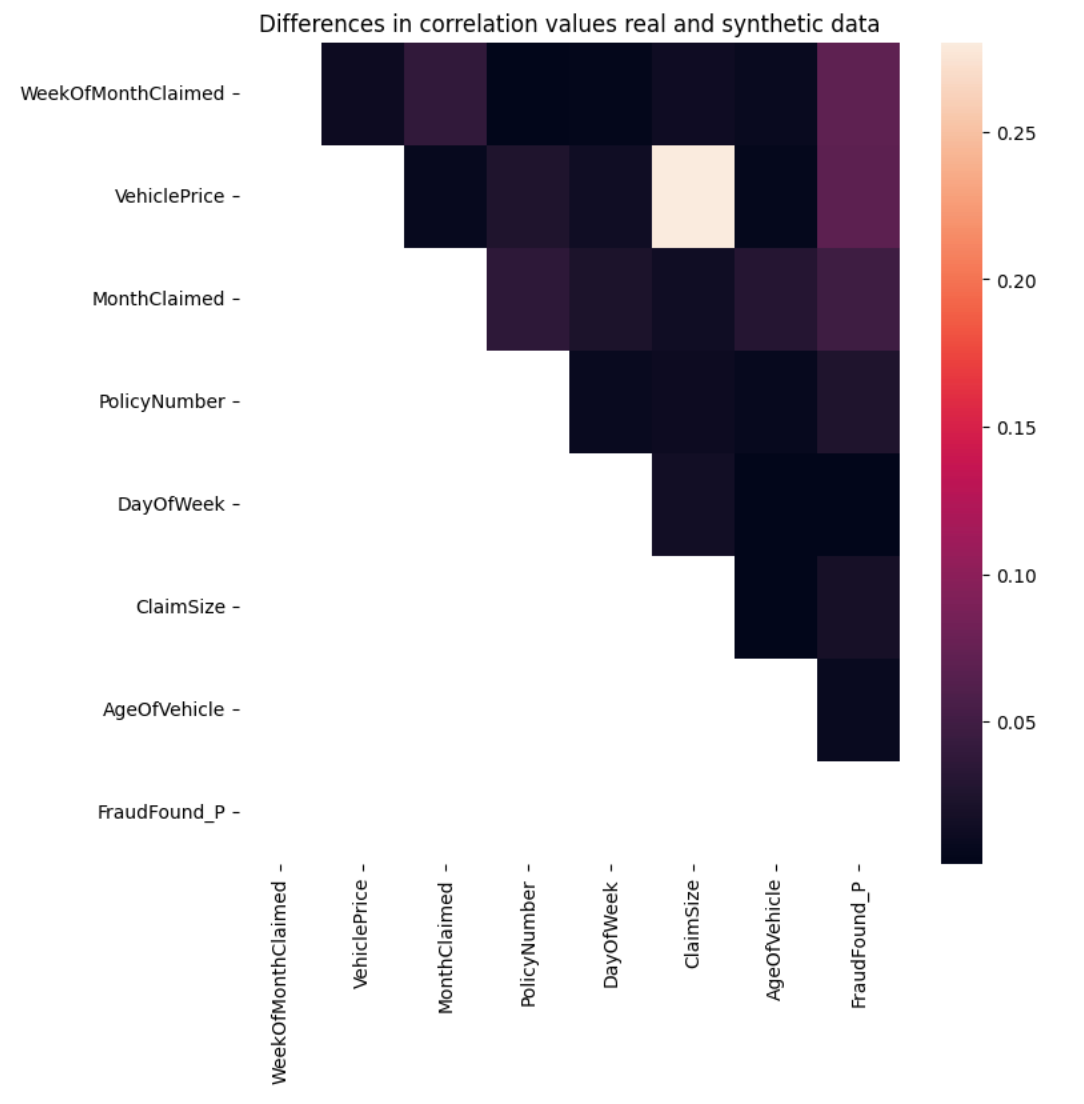

### Privacy Check

#### Creating privacy check object

Variables:


*   `original_data`: original dataset
*   `synthetic_data`: synthetic dataset
*   `metadata`: The metadata of the dataset (obtained above through the `generator_augment` function.





In [ ]:
privacy_checker = PrivacyCheck(df, synth, metadata)

#### Method to display privacy report

In [ ]:
privacy_checker.generate_report()

Here an example of output of this method: 

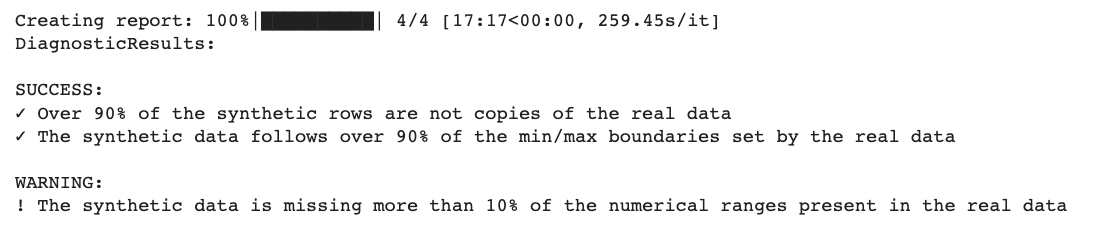

#### Method to display the results of the privacy report

In [ ]:
privacy_checker.get_results()

Here an example of output of this method:

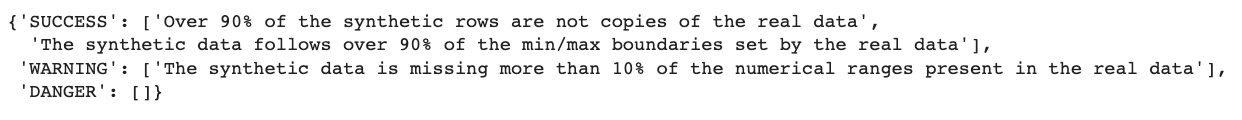

#### Method to display additional properties of the synthetic data
Variables:
*   `property_name` : String with the name of the property. One of 'Synthesis', 'Coverage' or 'Boundaries'




In [ ]:
privacy_checker.get_details('Coverage')

Here an example of output of this method. The diagnostic score ranges from 0 to 1.

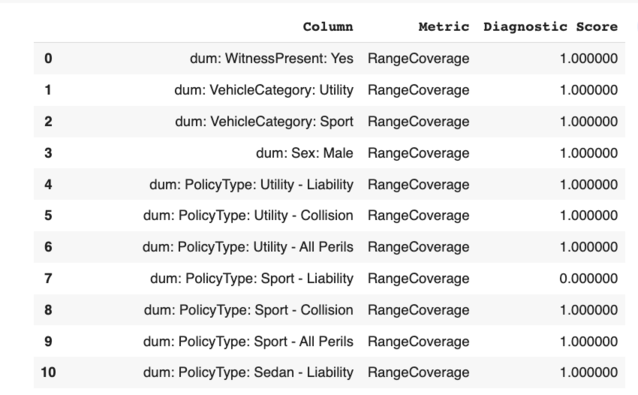

#### Method to display a summary of the  properties of the synthetic data




In [ ]:
privacy_checker.get_properties()

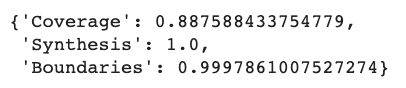

#### Method to display visualization of the properties of the synthetic data
Variables:
*   `property_name` : String with the name of the property. One of 'Synthesis', 'Coverage' or 'Boundaries'




In [ ]:
privacy_checker.get_visualization('Coverage')

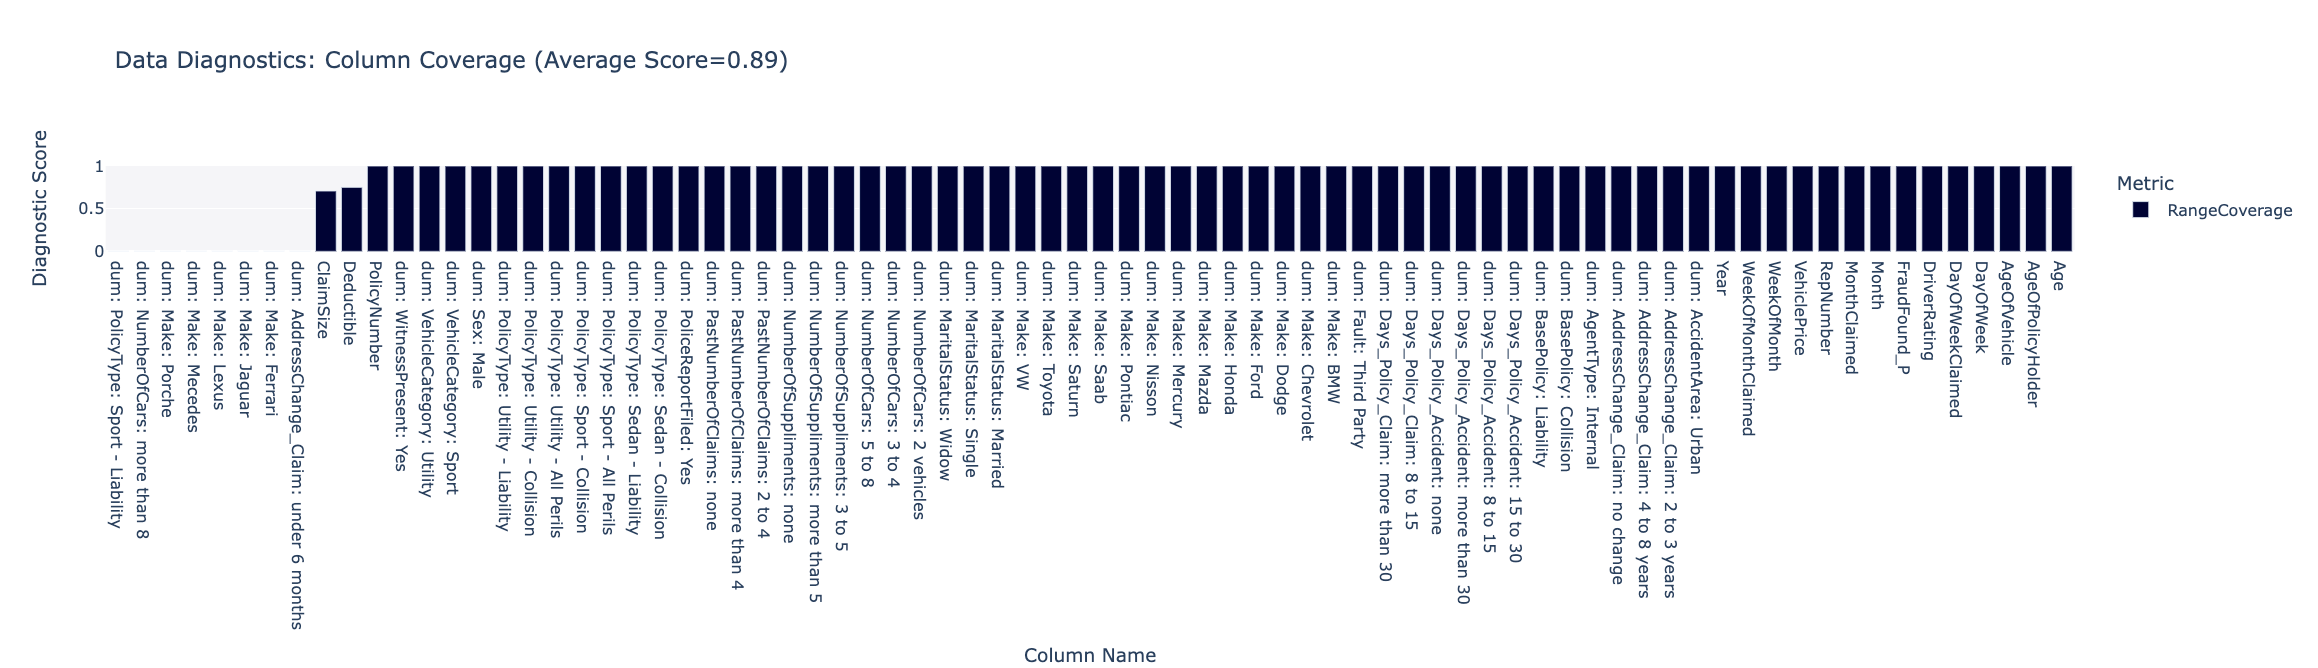

#### Method to find the index of nearest neighbours in original and synthetic dataset
Variables:
*   `sensitive_columns`: (optional) list to specify columns that should play a role for distance computation
*   `verbose`:(optional) boolean that controls the verbosity of the output, default True


In [ ]:
privacy_checker.find_nearest_neighbours()

Below, an example of the type of output of this method. The first number is the index of the datapoint in the original dataset, the second number is the index of the closest datapoint in the synthetic dataset. The third number is the distance between them.

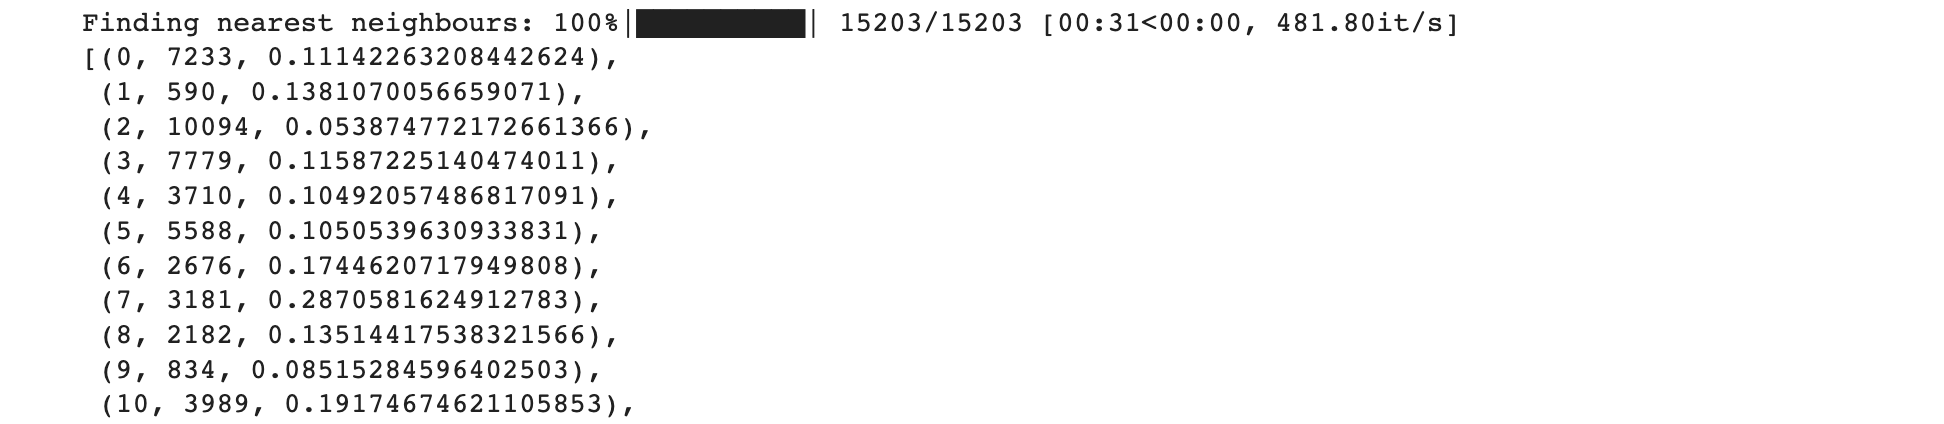

#### Method to display the k nearest neighbours

Variables:
*   `k` : number of closest pairs to display.
*   `display`: (bool) print the content of the closest pairs? Default False


In [ ]:
privacy_checker.get_closest_pairs(2)

Here an example of output of this method: The table returns the references to the closest pairs and their distance.

If display = True the function also prints the pairs so that the user can analyze them better.

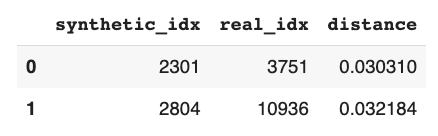